# ABS Monthly Labour Force 6202

## Python set-up

In [1]:
# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    #clear_cache,
    get_abs_meta_and_data,
    get_fs_constants,
    get_identifier,
    get_meta_constants,
    get_plot_constants,
    plot_rows_collectively,
    plot_rows_individually,
    plot_rows_seas_trend,
)
from plotting import (
    calc_and_plot_growth,
    clear_chart_dir,
    line_plot,
    plot_covid_recovery,
    set_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 999

# display all charts in this notebook ...
SHOW = True

## Get data from ABS

In [2]:
CAT_ID = "6202"
source, CHART_DIR, META_DATA = get_fs_constants(CAT_ID)
abs_dict = get_abs_meta_and_data(CAT_ID, verbose=False)
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col, tdesc_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
About to download and cache the latest data.
Saving to cache: ABS_CACHE/842830b693f9b921bbe3abd5bbd8f4d8--p6202_all_monthly_spreadsheets.zip
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [3]:
def chart_settings(chart_dir: str = CHART_DIR) -> None:
    """Set up charting parameters."""

    set_chart_dir(chart_dir)
    clear_chart_dir(chart_dir)
    plt.style.use("fivethirtyeight")


chart_settings()

### Headline seasonally adjusted/trend charts

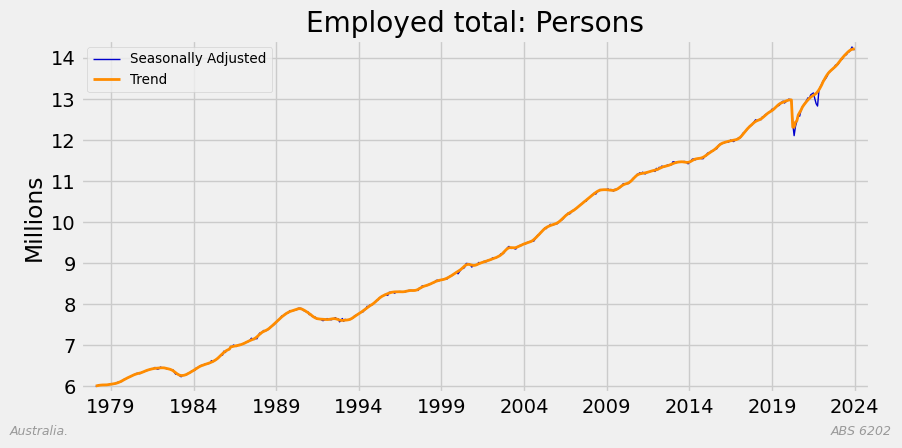

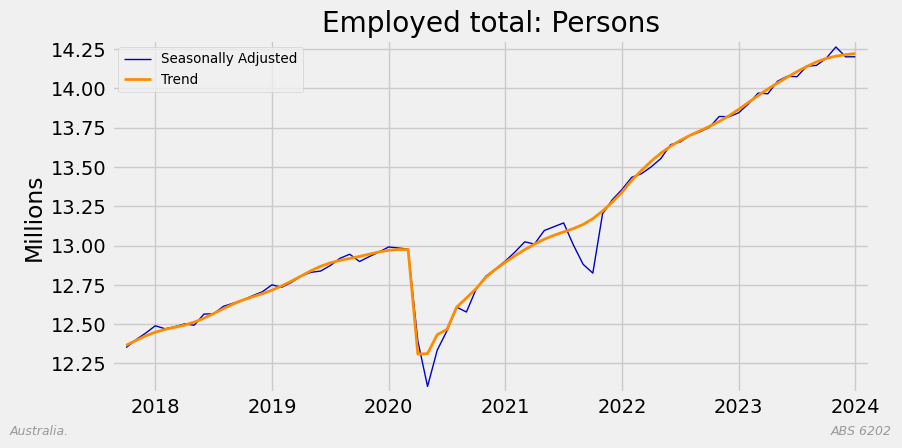

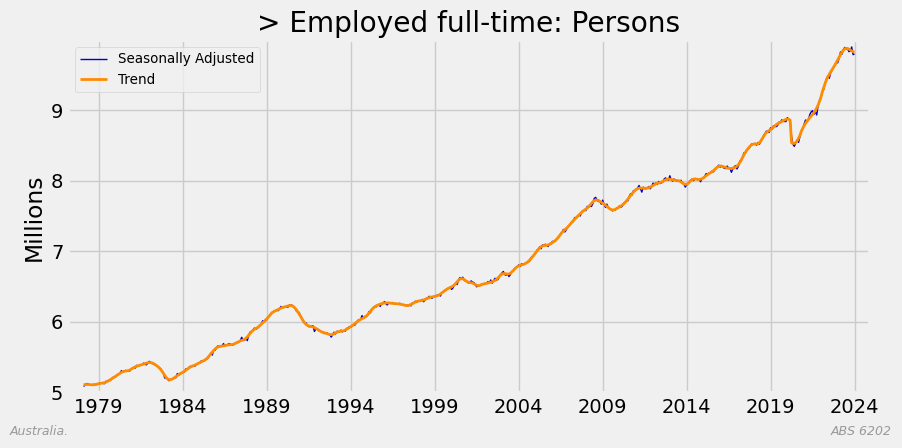

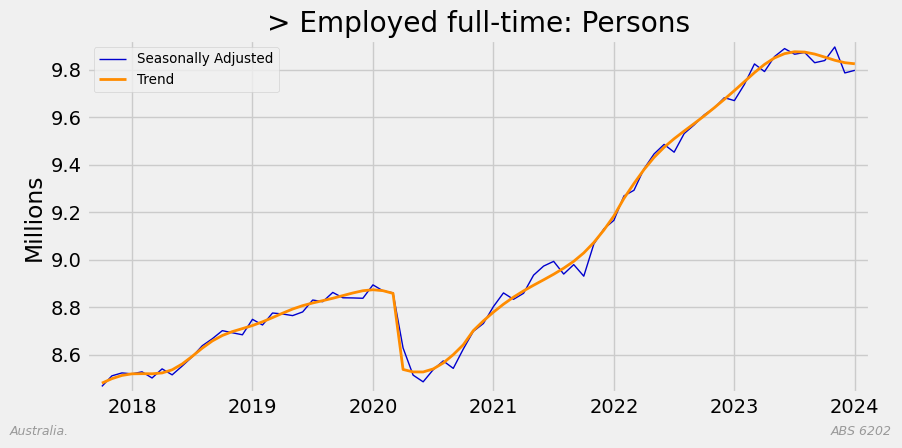

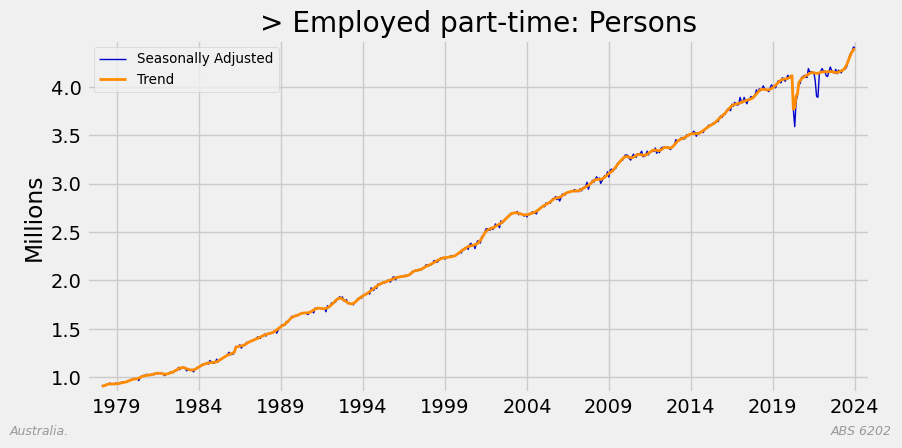

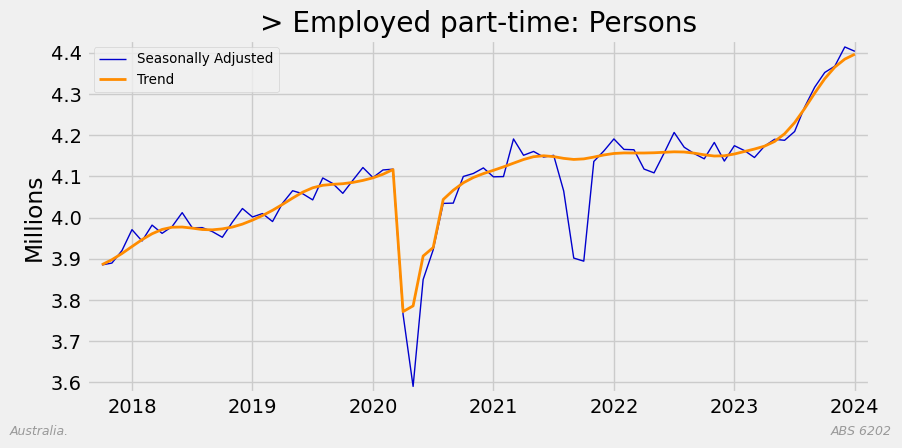

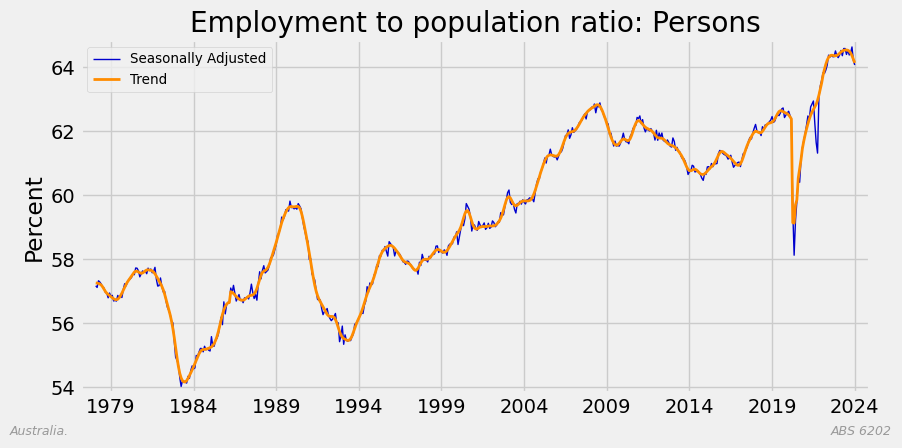

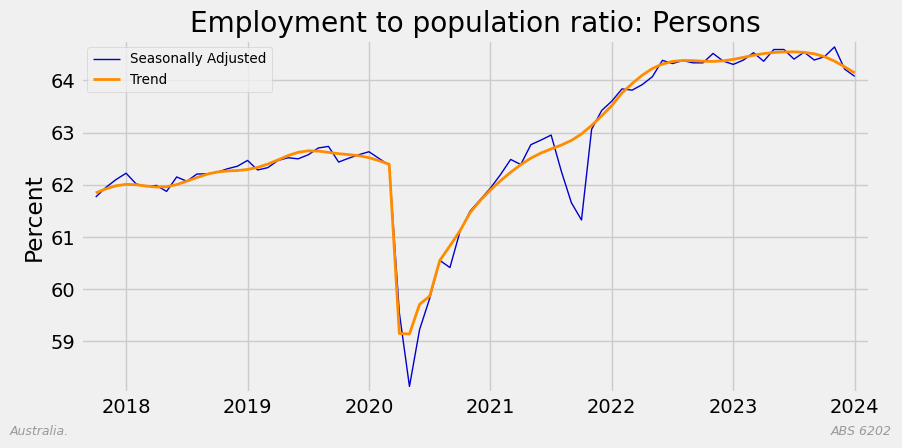

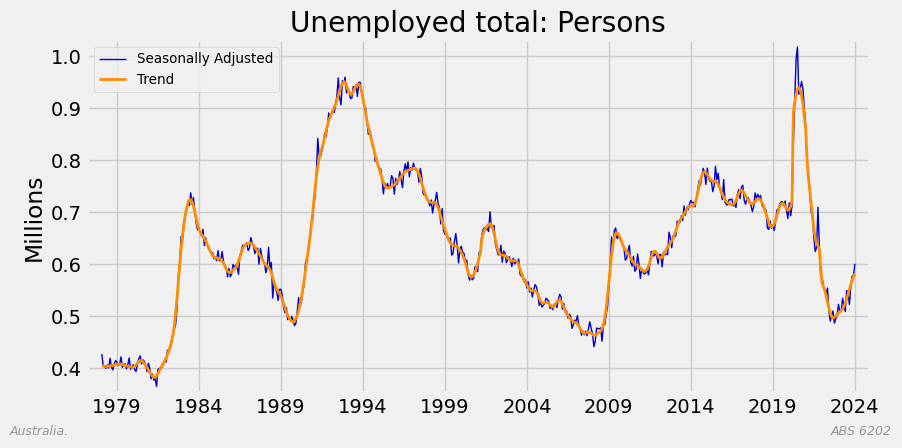

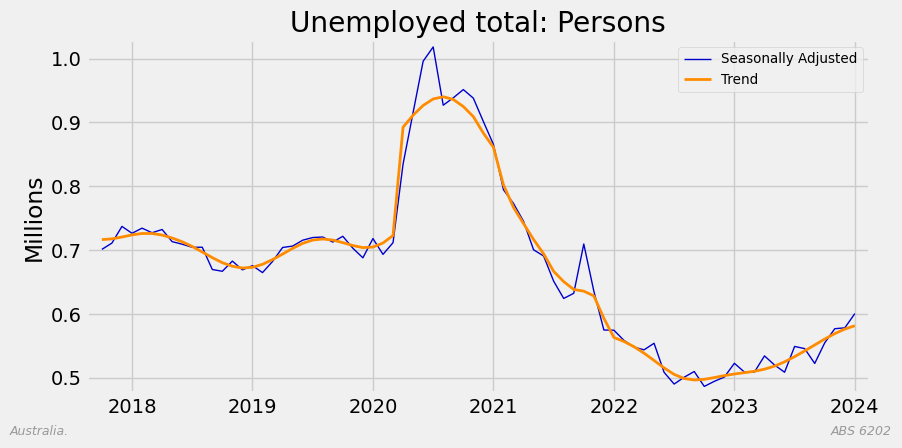

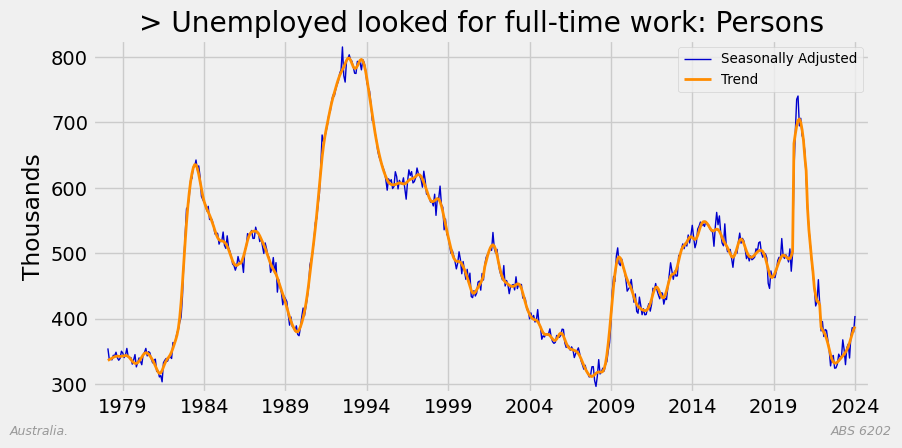

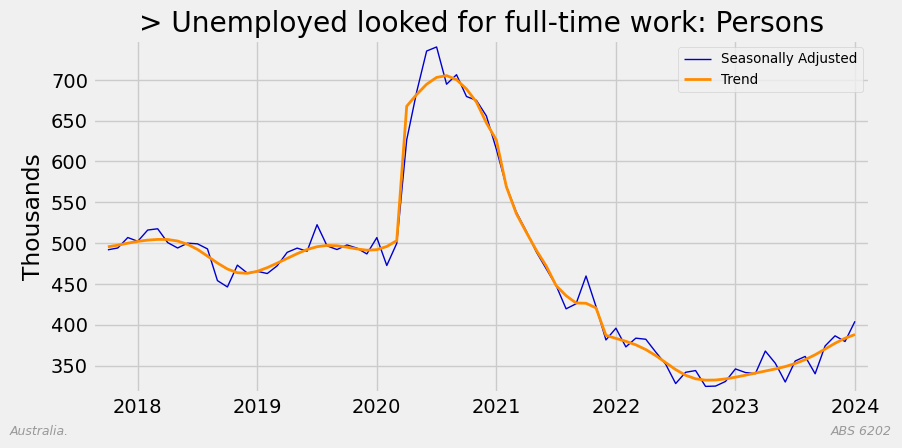

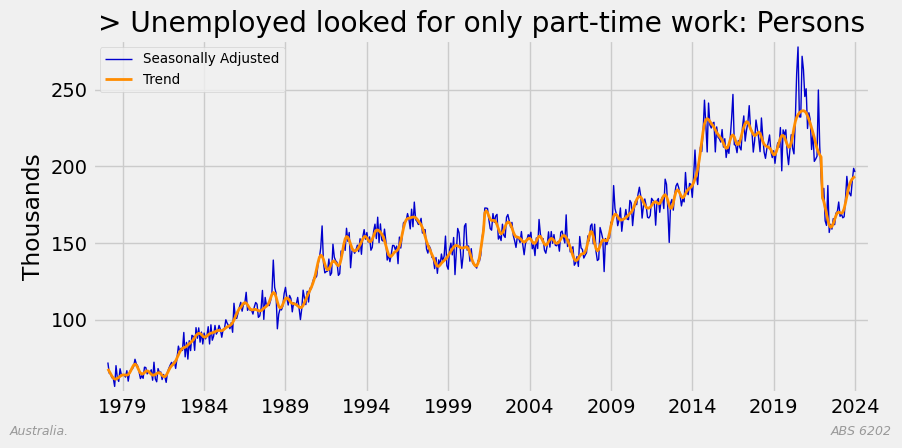

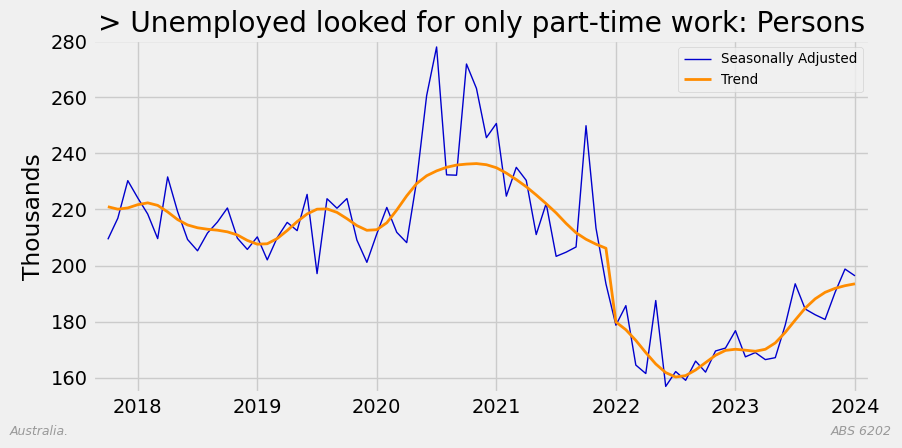

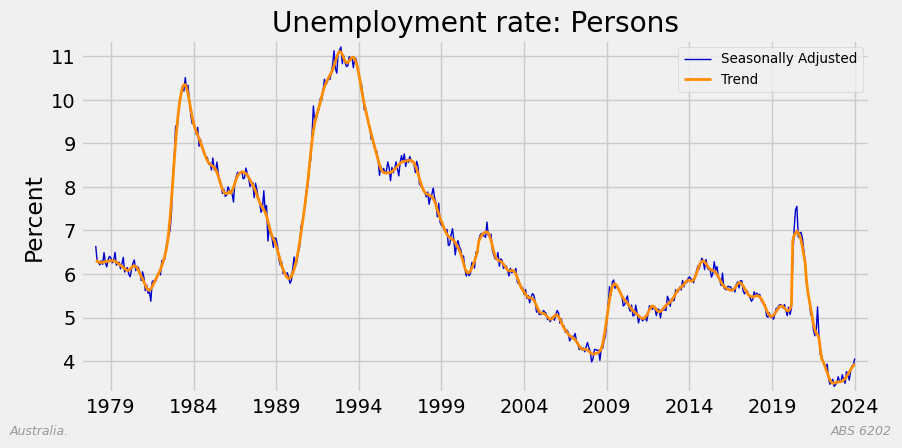

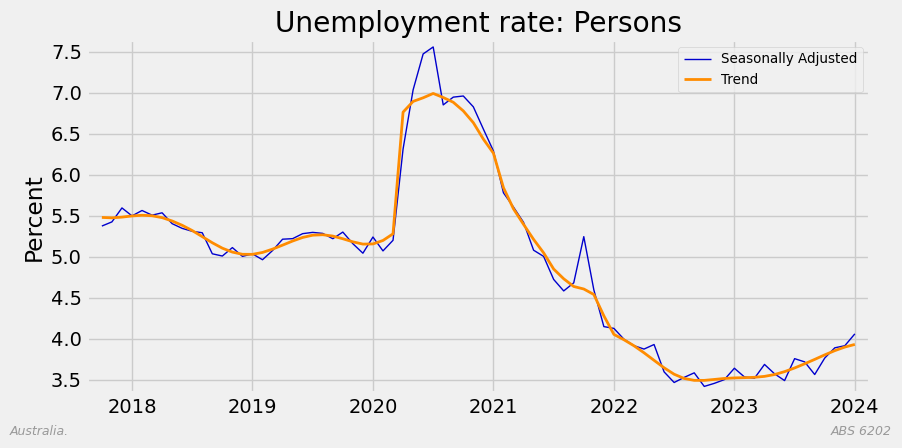

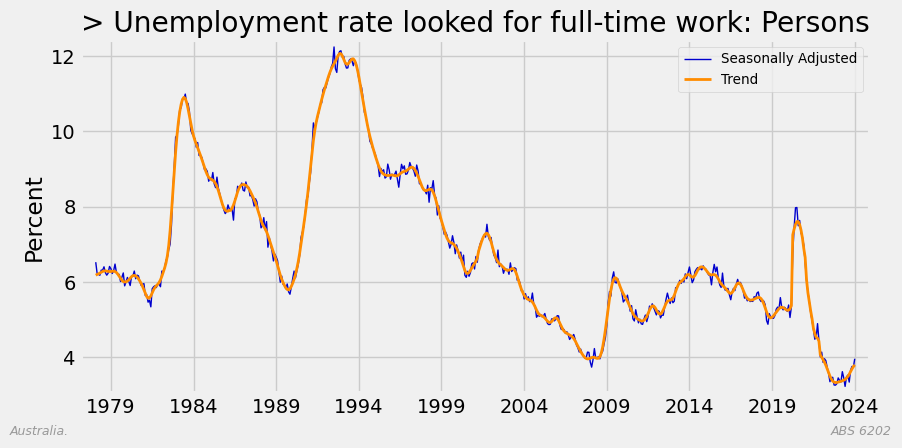

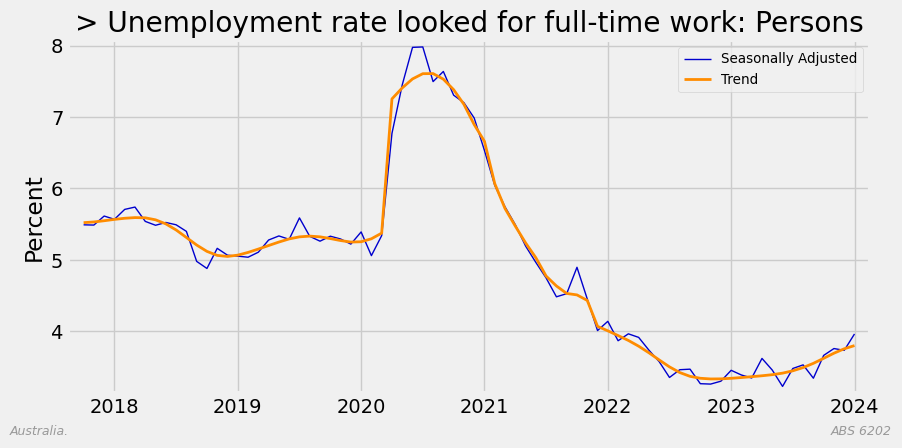

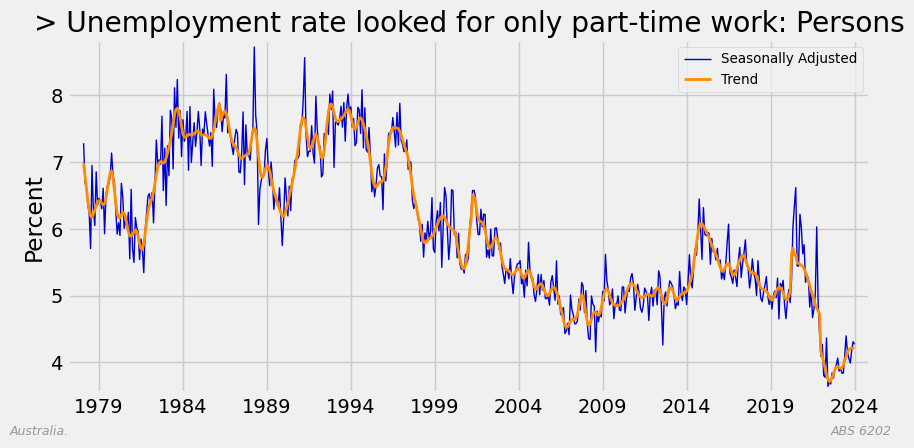

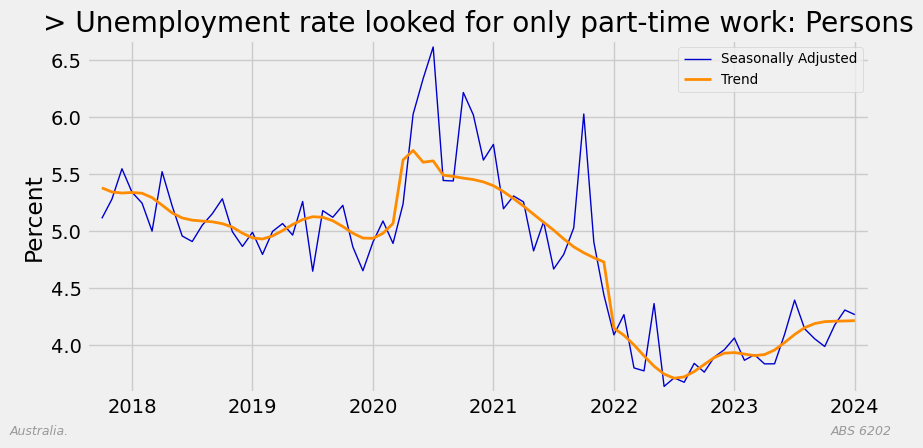

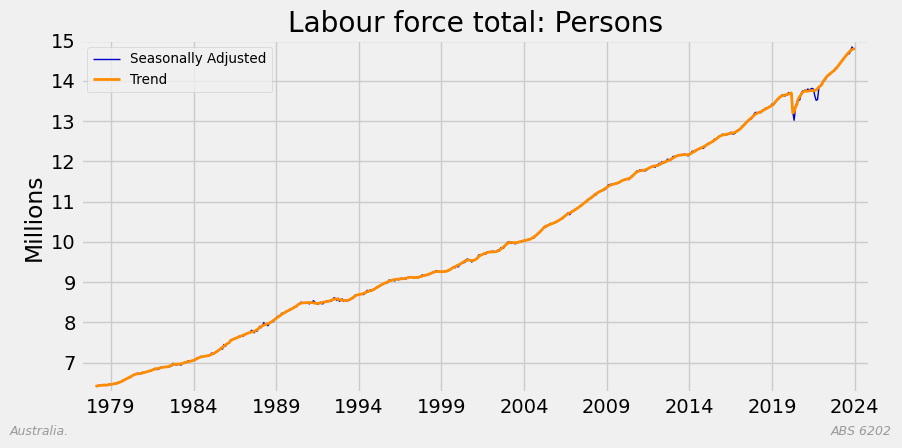

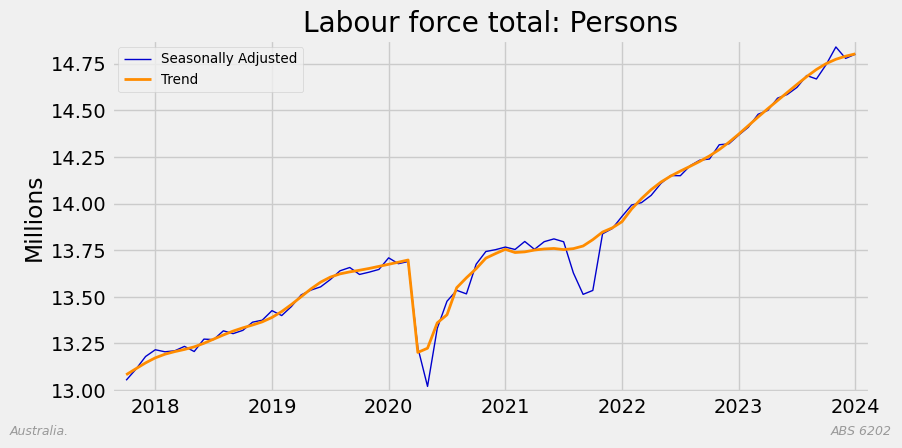

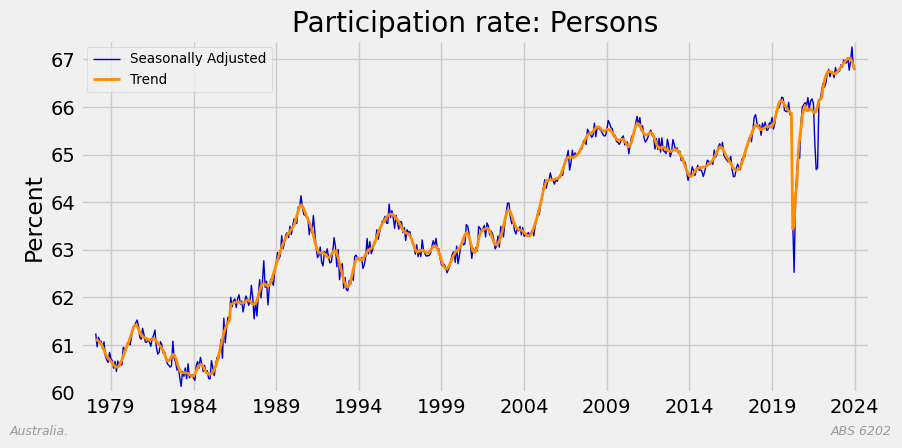

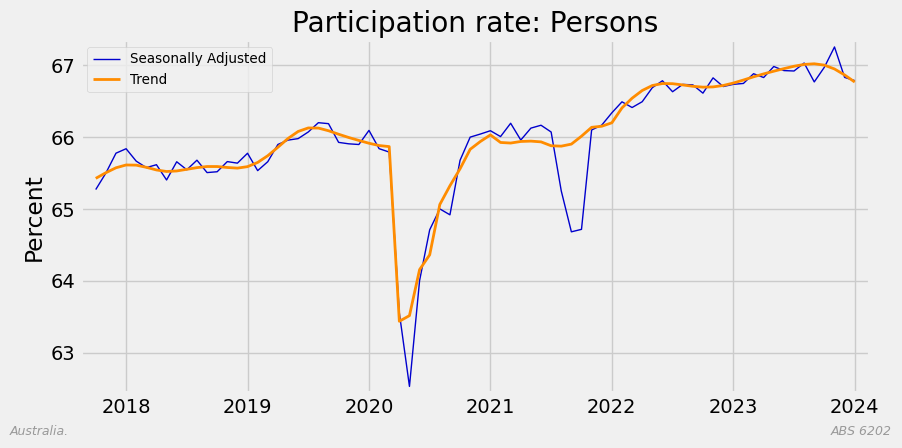

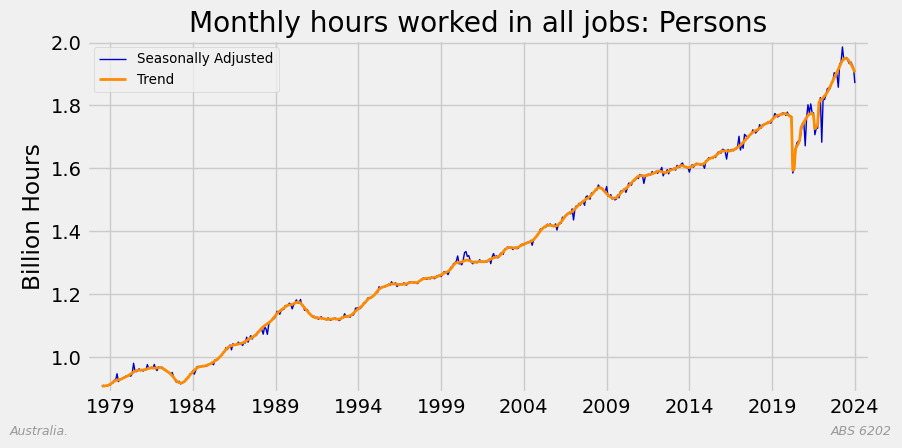

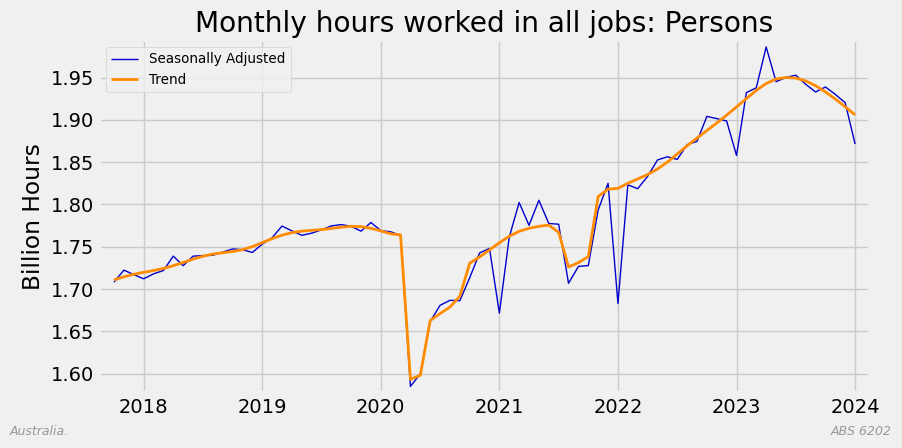

In [4]:
def headline_charts():
    """Produce headline charts."""

    selector1 = {
        "1": table_col,
        "Persons": did_col,
    }

    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": did_col,
        "19": table_col,
    }

    for selector in (selector1, selector2):
        plot_rows_seas_trend(
            abs_dict,
            selector,
            starts=plot_times,
            tags=plot_tags,
            rfooter=source,
            lfooter="Australia. ",
            verbose=False,
            show=SHOW,
        )


headline_charts()

### Headline COVID recovery charts

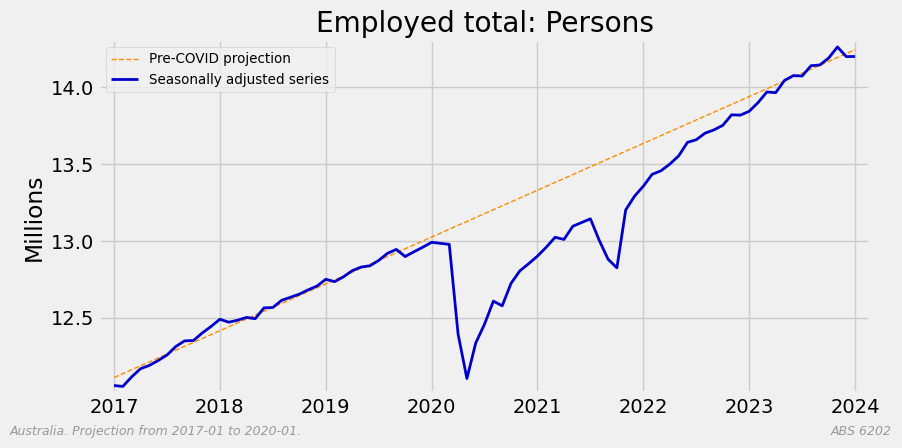

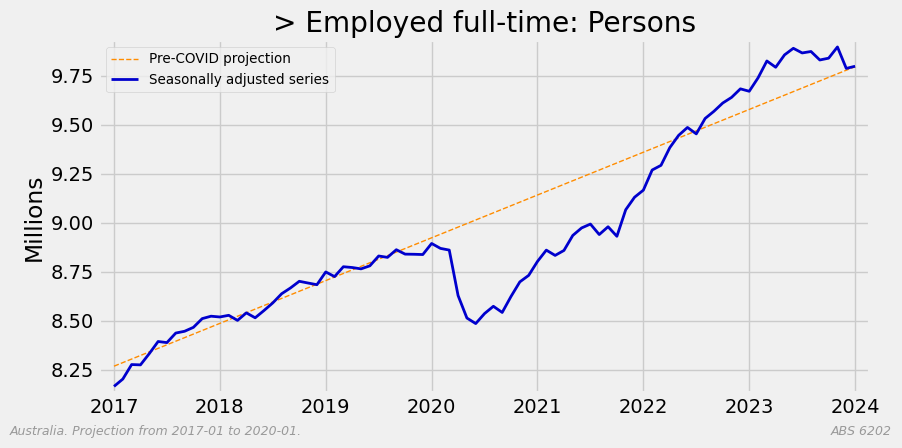

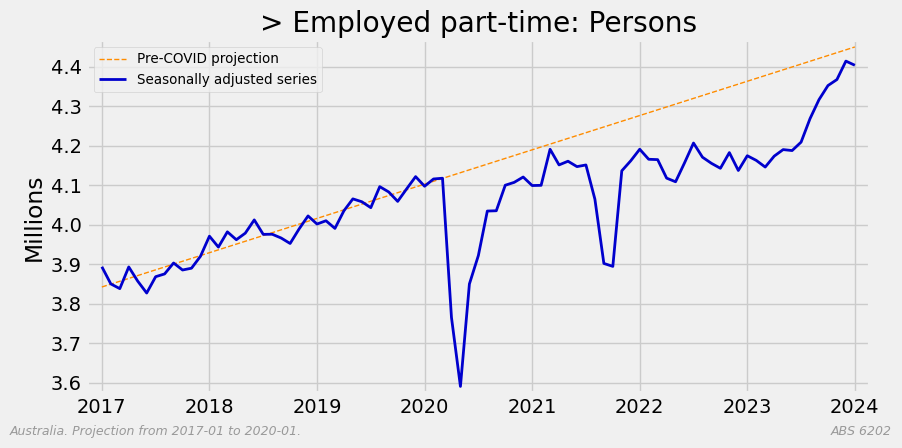

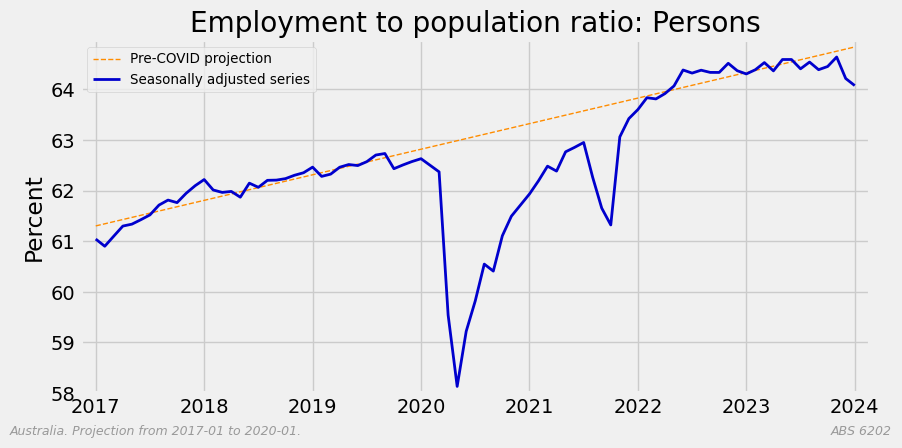

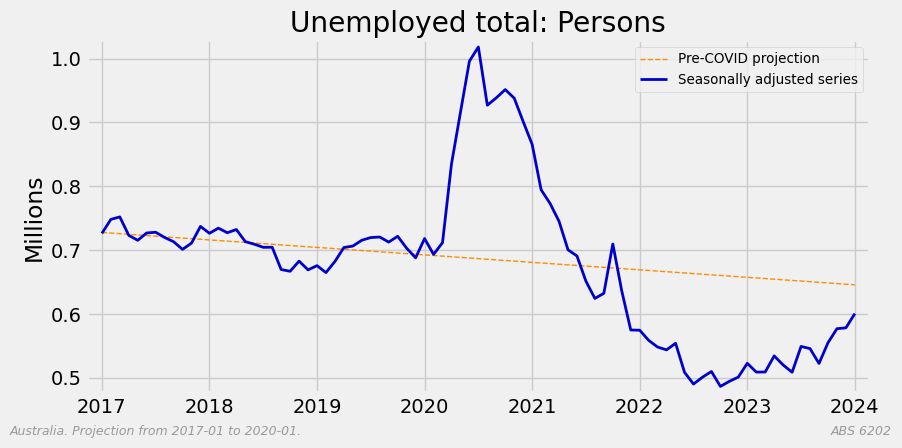

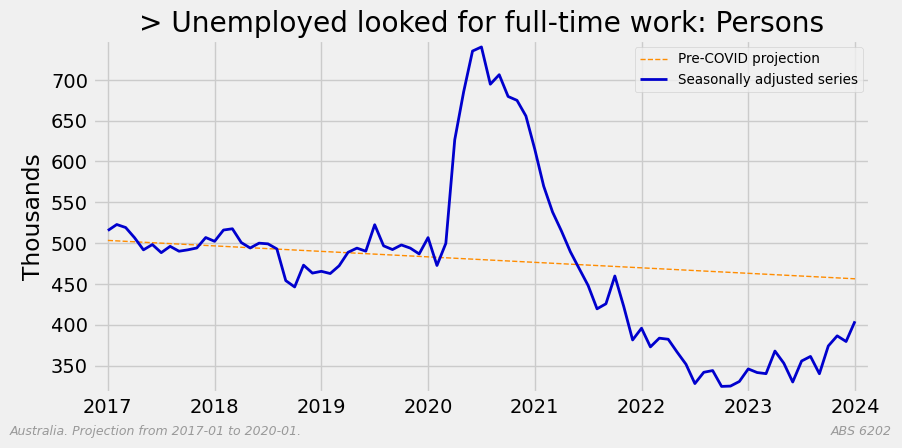

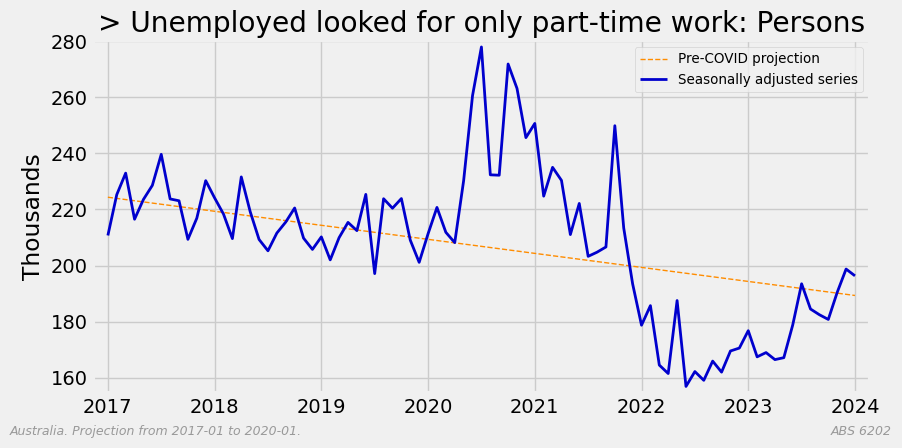

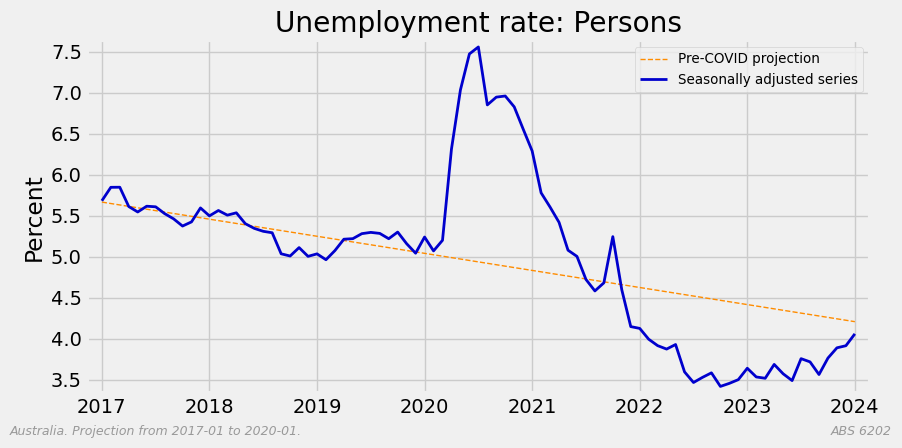

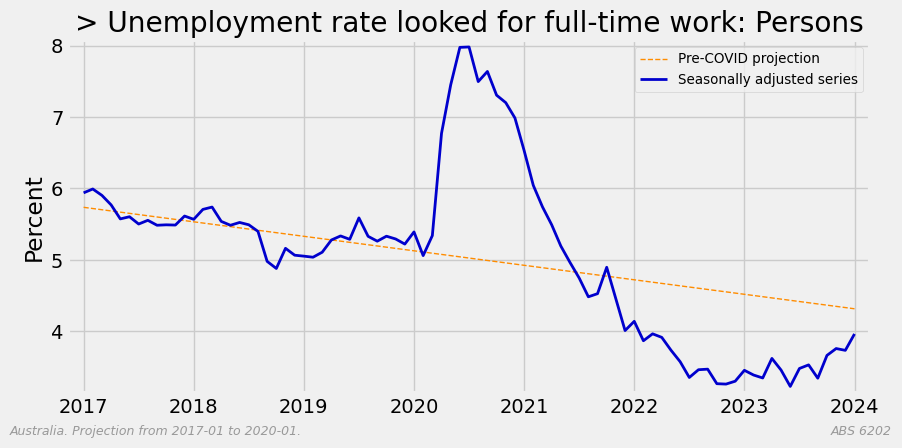

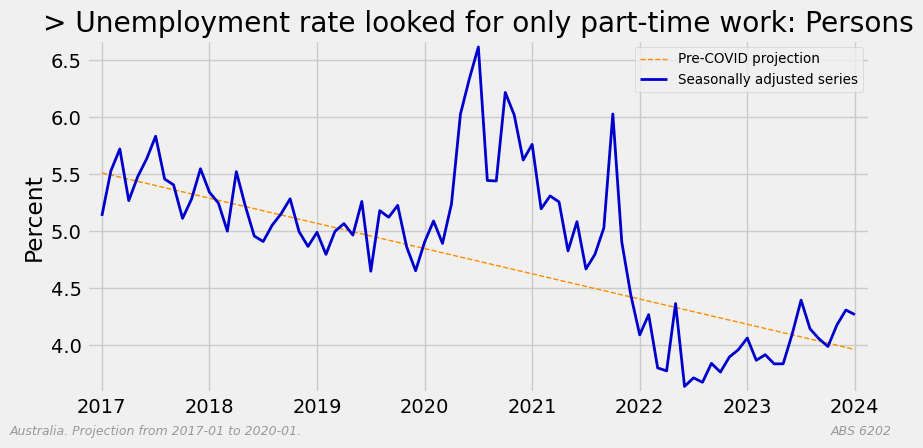

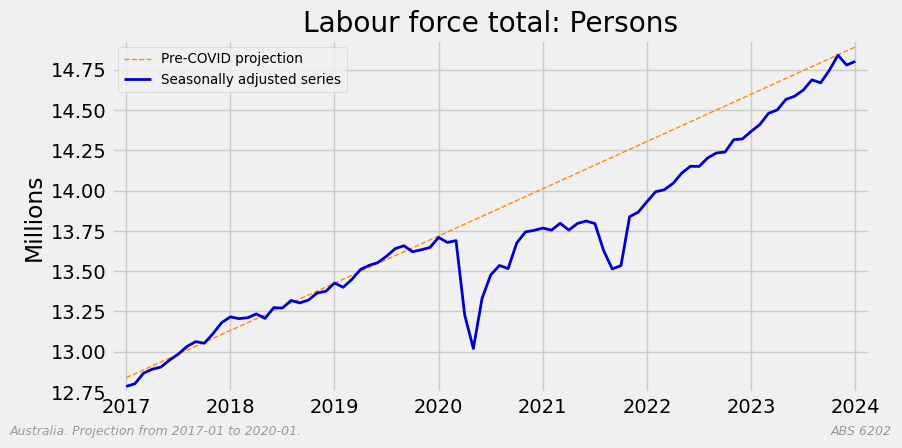

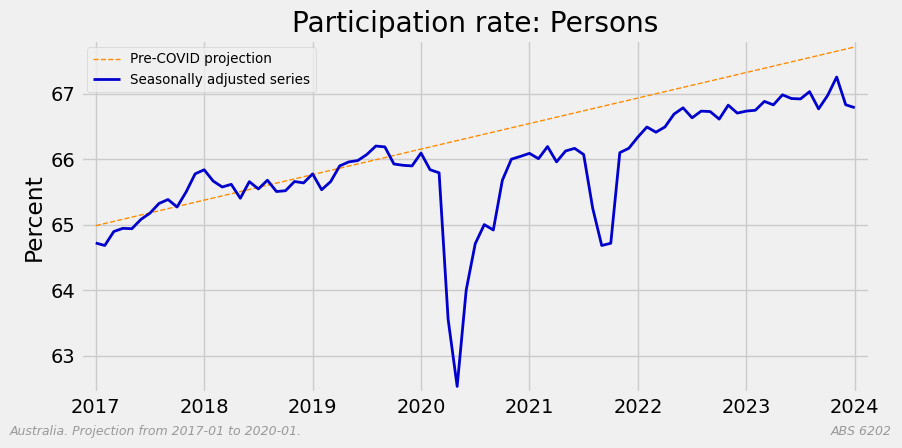

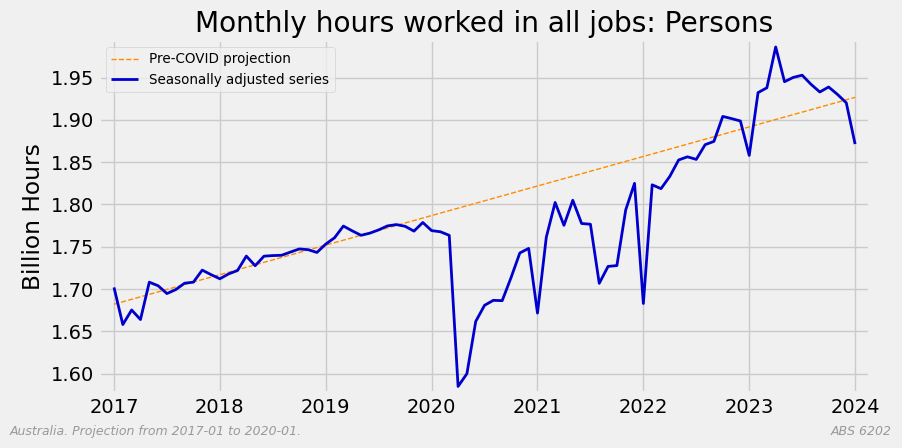

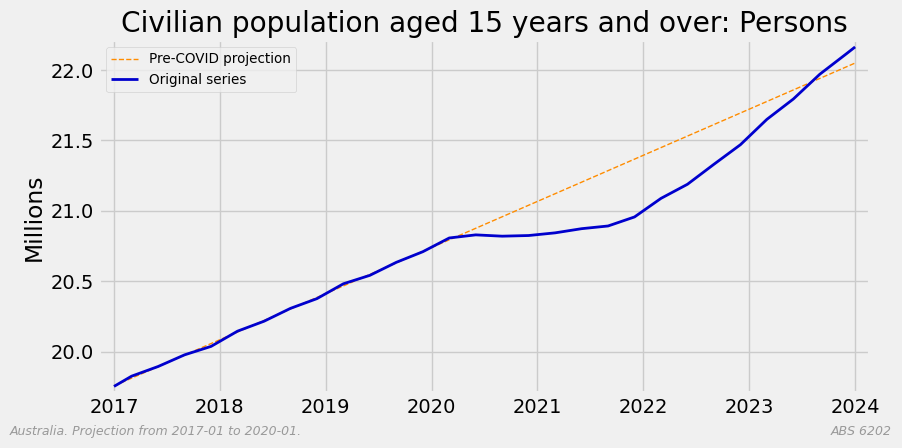

In [5]:
def covid_charts():
    """Produce pre/post COVID trajectory charts."""

    service_type = "Seasonally Adjusted"
    selector1 = {
        "Persons": did_col,
        "1": table_col,
        service_type: type_col,
    }
    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": did_col,
        "19": table_col,
        service_type: type_col,
    }
    selector3 = {
        "Original": type_col,
        "1": table_col,
        "Civilian population aged 15 years and over ;  Persons ;": did_col,
    }

    for selector in (selector1, selector2, selector3):
        plot_rows_individually(
            abs_dict,
            selector=selector,
            plot_function=plot_covid_recovery,
            tags="COVID",
            rfooter=source,
            lfooter="Australia. ",
            show=SHOW,
        )


covid_charts()

### State comparisons 

In [6]:
# use linestyle to help differentiate datasets ...
linestyle = {
    "style": [
        "-.",
        "-",
        "--",
        ":",
    ]
    * 3  # repeat enough to cover all series
}

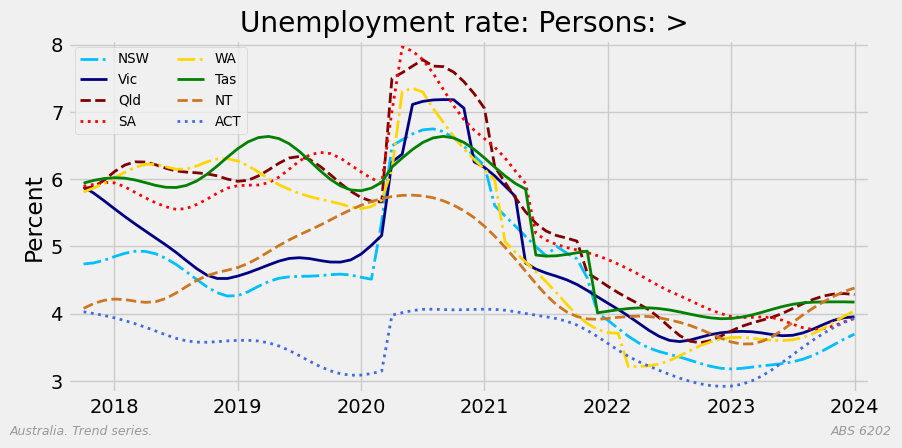

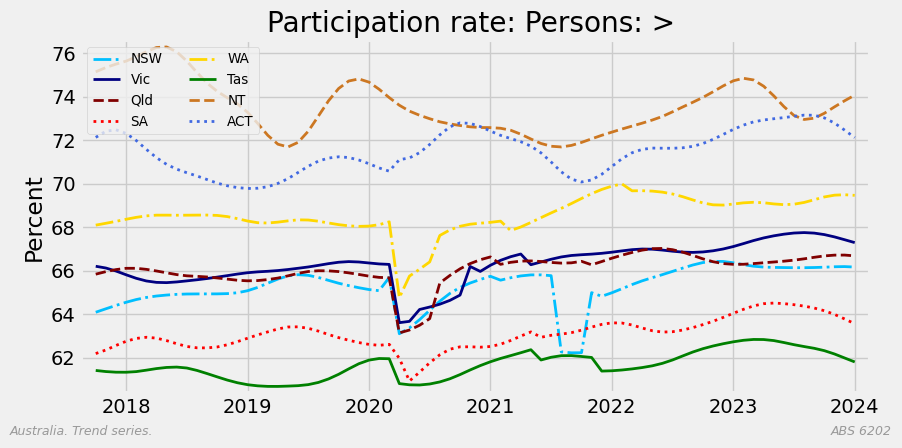

In [7]:
def state_charts():
    """Produced trend charts for states."""

    states = (
        "New South Wales|Victoria|Queensland|South Australia"
        "|Western Australia|Tasmania|Northern Territory|Australian Capital Territory"
    )
    # service_type = "Seasonally Adjusted"
    service_type = "Trend"
    selector = {
        states: did_col,
        service_type: type_col,
    }
    plot_stems = [
        "Unemployment rate ;  Persons",
        "Participation rate ;  Persons",
    ]

    for stem in plot_stems:
        xselector = {**selector, stem: did_col}
        plot_rows_collectively(
            abs_dict,
            selector=xselector,
            regex=True,
            starts=RECENT,
            **linestyle,
            legend={"loc": "upper left"},
            rfooter=source,
            lfooter=f"Australia. {service_type.capitalize()} series.",
            show=SHOW,
        )


state_charts()

### Headline Growth

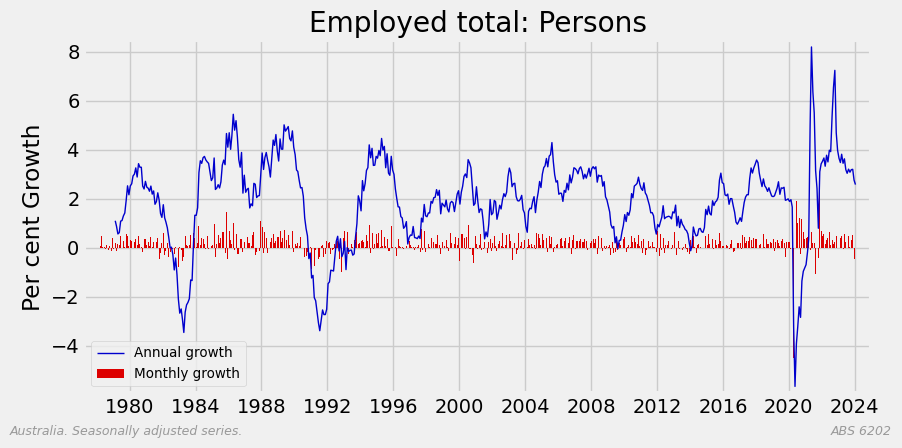

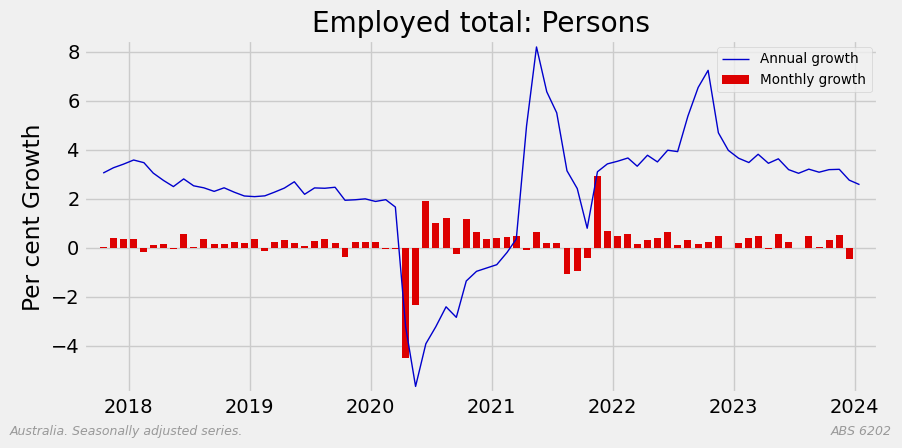

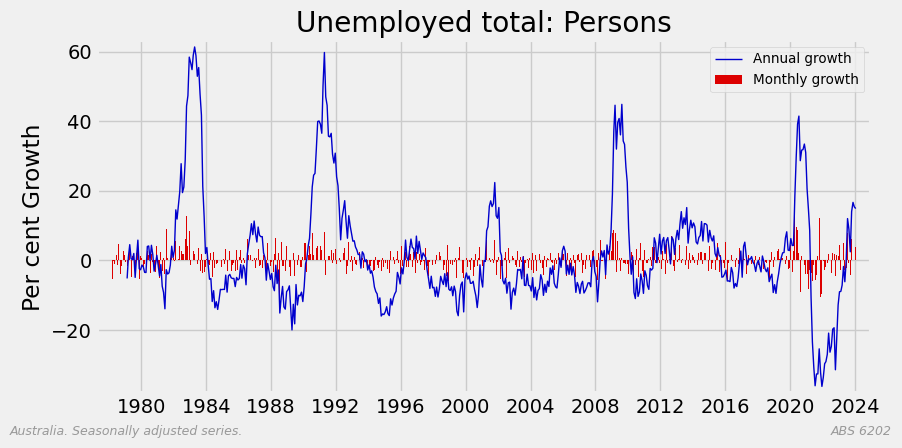

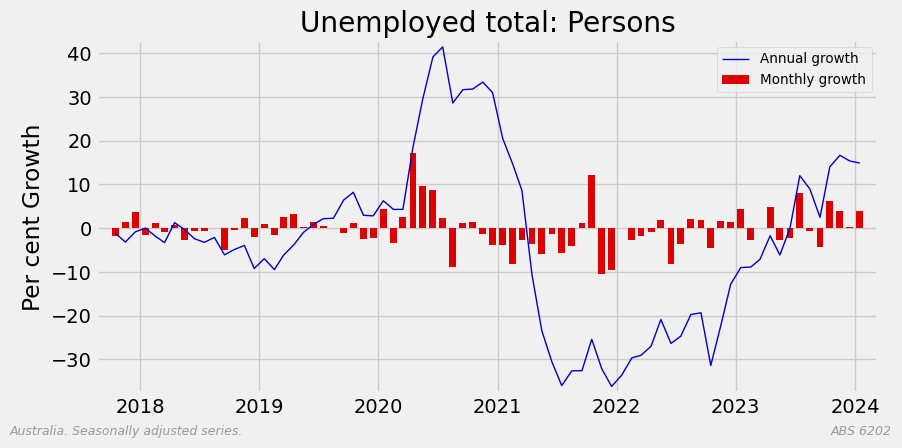

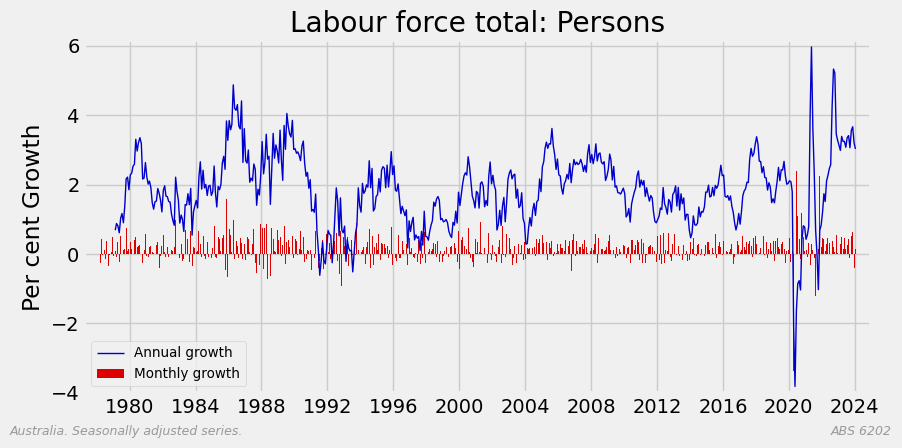

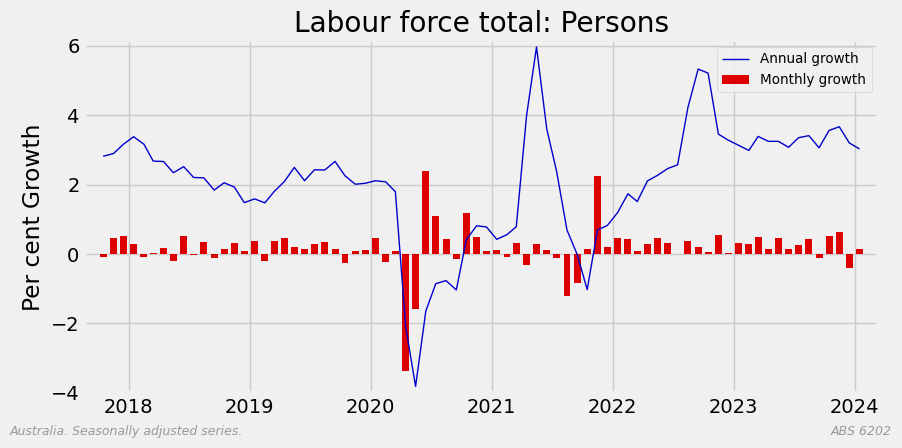

In [8]:
def growth_charts():
    """Produce growth charts."""

    plot_stems = "|".join(
        [
            "Employed total ;  Persons ;",
            "Unemployed total ;  Persons ;",
            "Labour force total ;  Persons ;",
        ]
    )

    service_type = "Seasonally Adjusted"
    plot_rows_individually(
        abs_dict,
        # data selection
        selector={"1": table_col, plot_stems: did_col, service_type: type_col},
        regex=True,
        # plotting
        plot_function=calc_and_plot_growth,
        from_=plot_times,
        tag="growth",
        rfooter=source,
        lfooter=f"Australia. {service_type.capitalize()} series. ",
        show=SHOW,
    )


growth_charts()

### Gendered comparisons

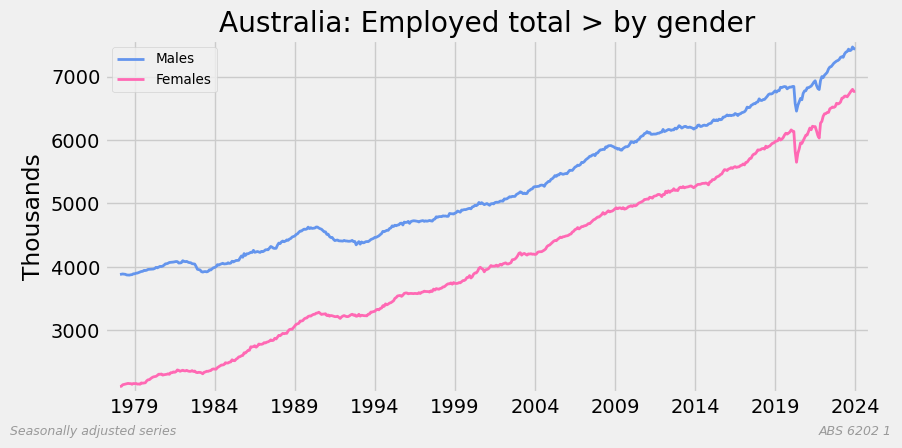

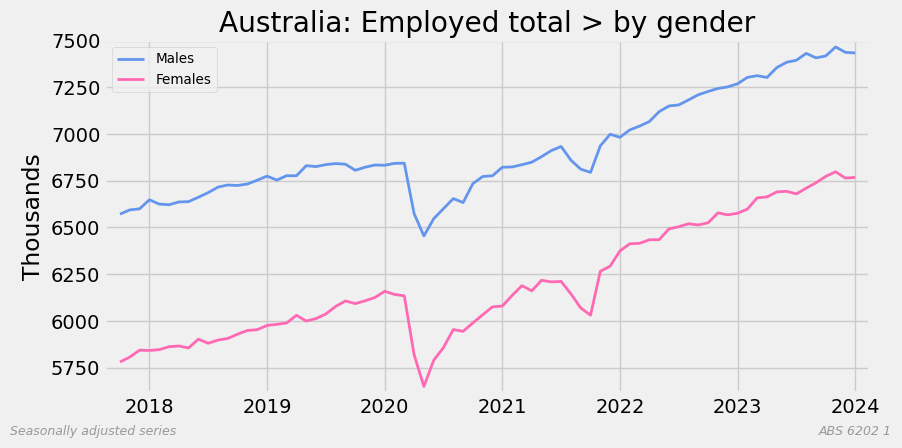

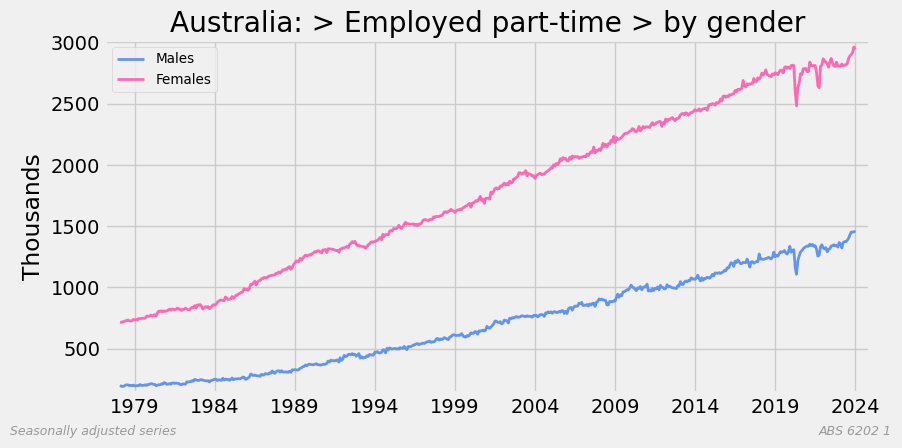

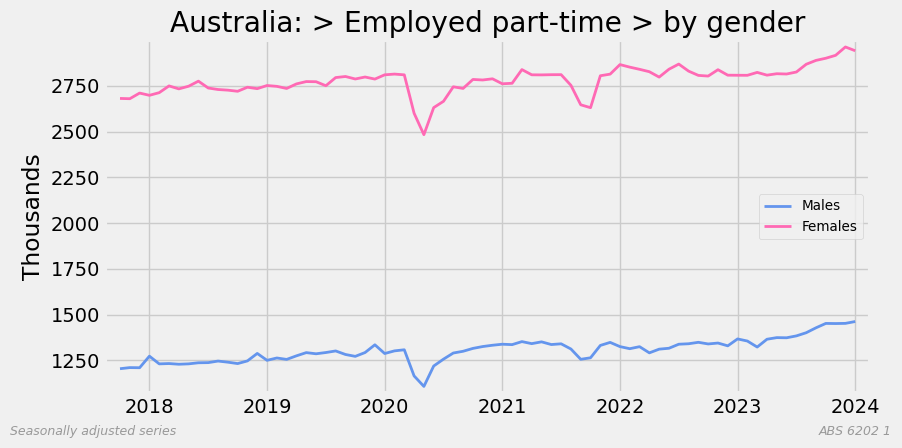

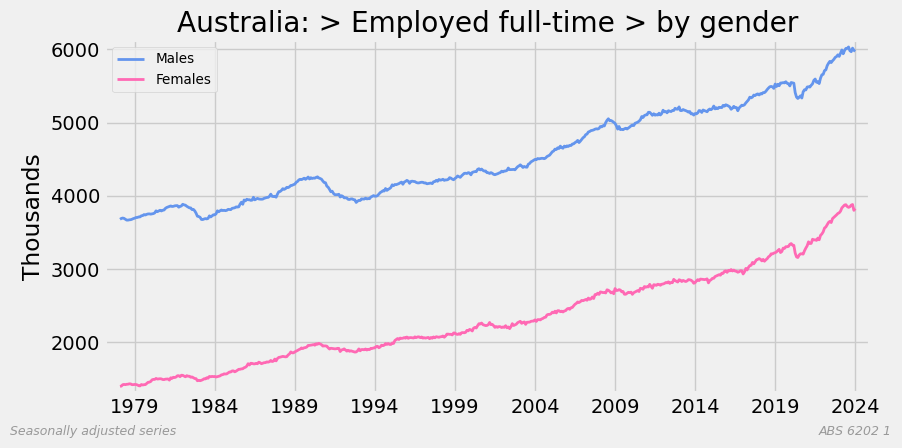

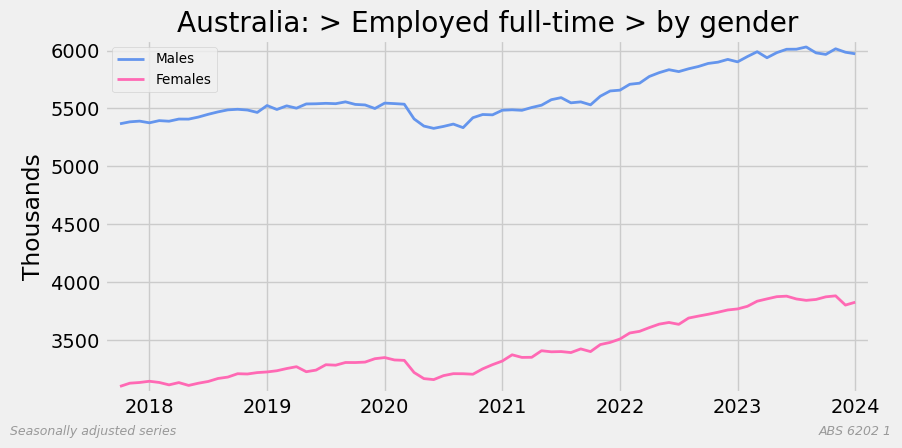

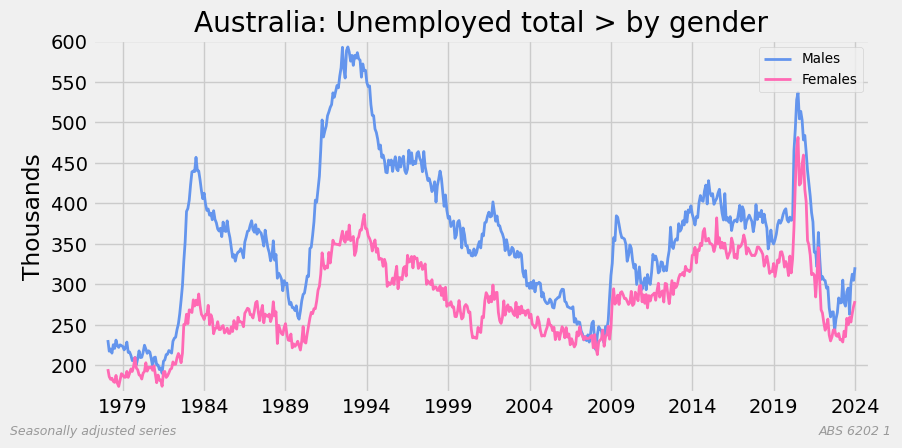

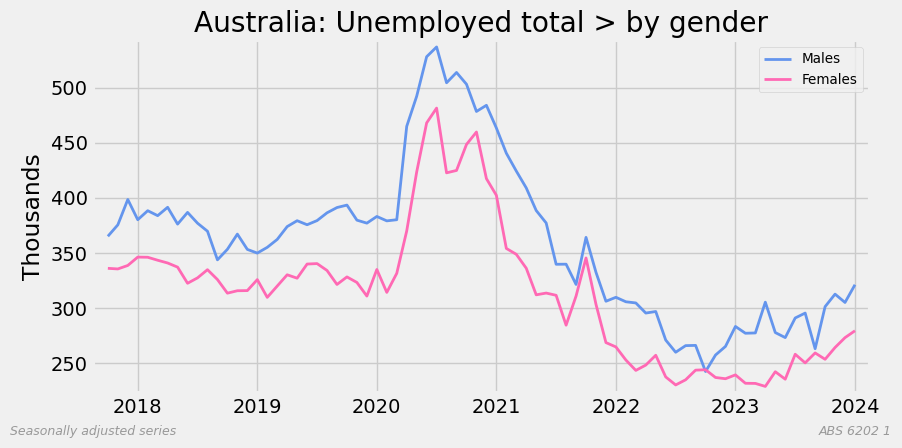

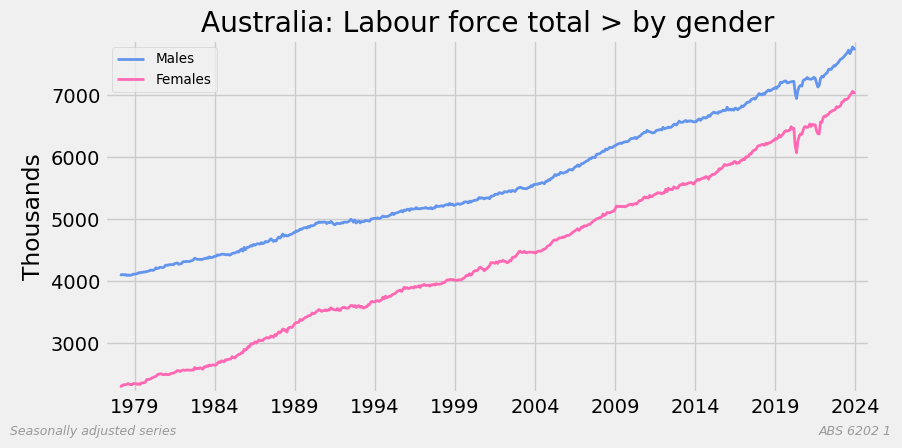

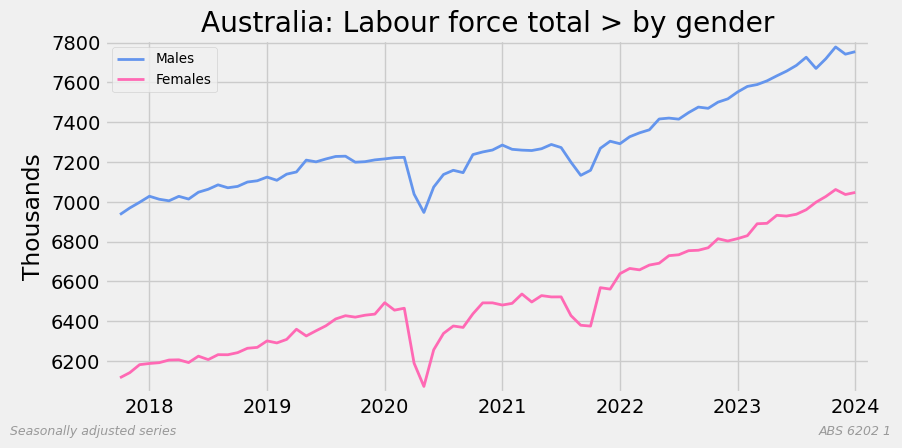

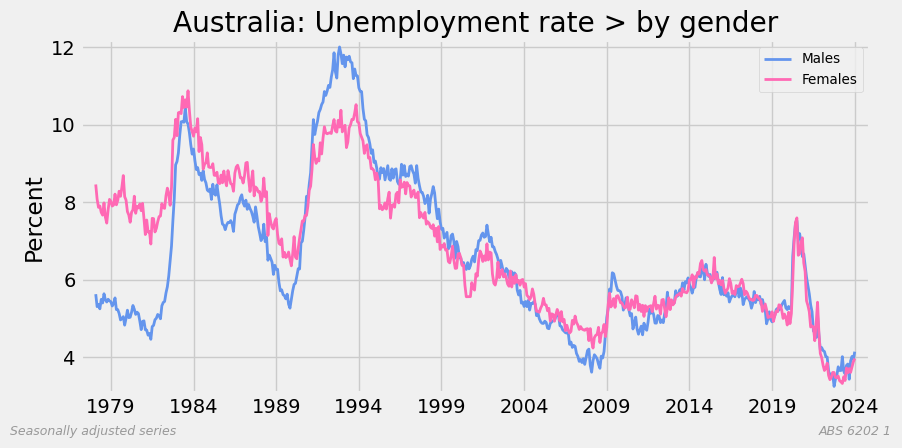

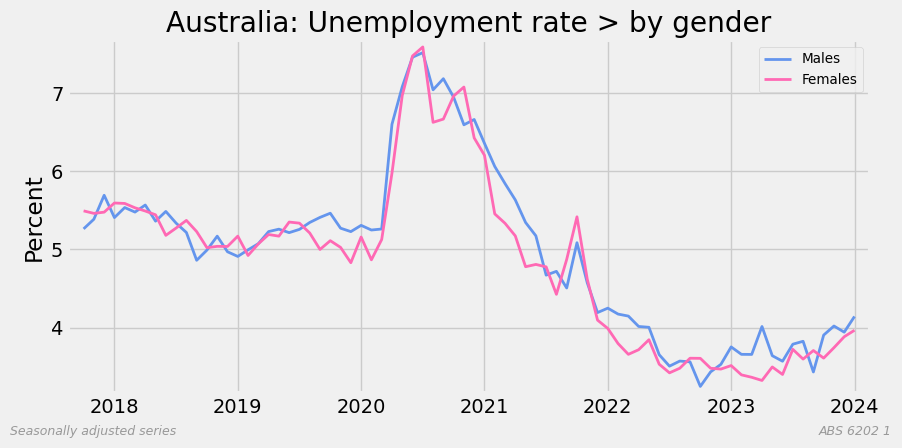

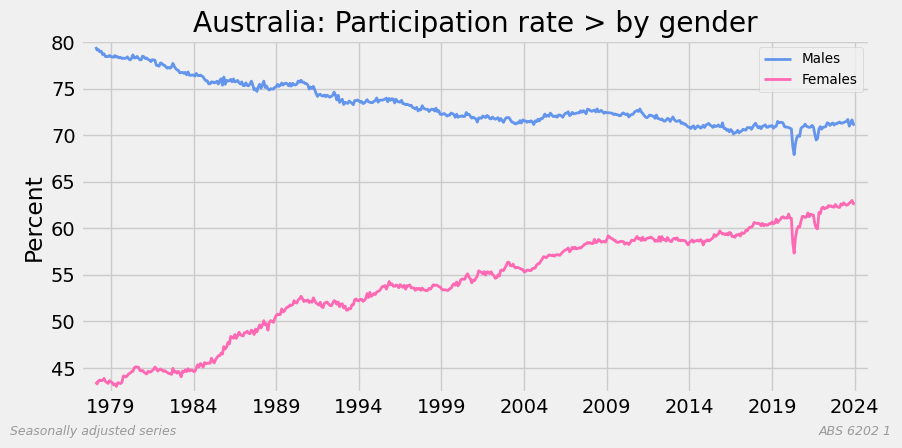

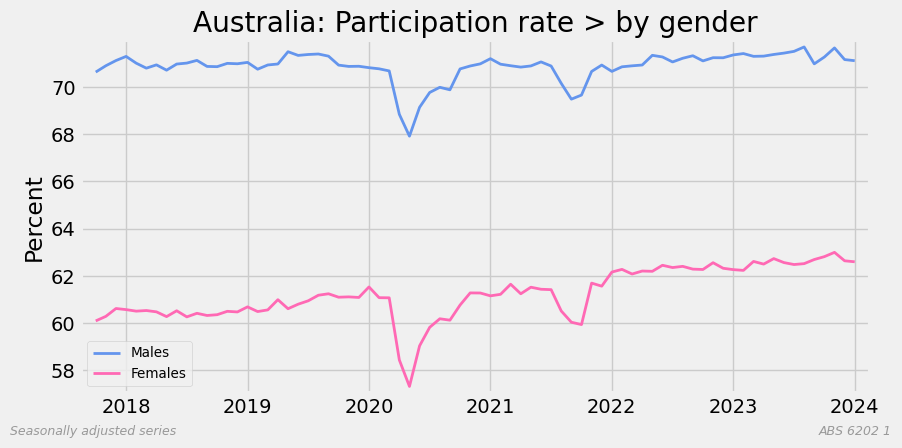

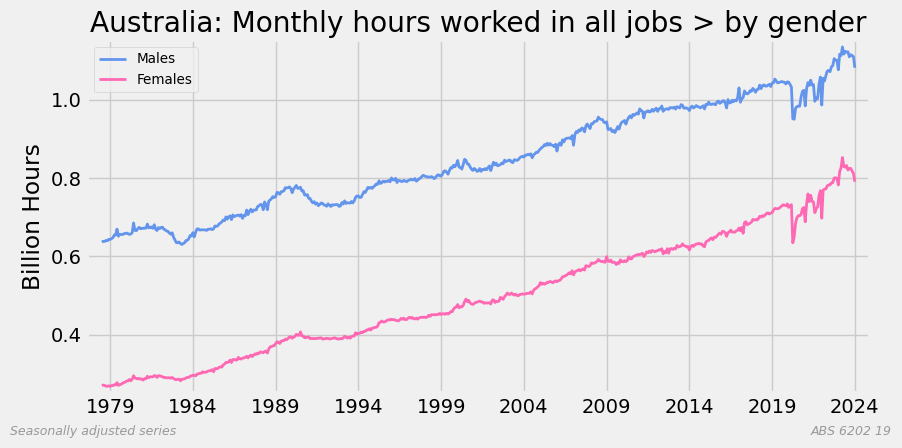

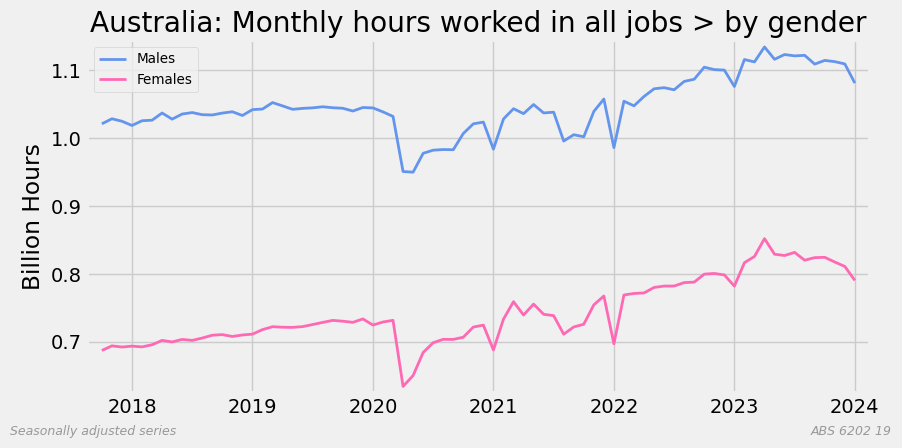

In [9]:
def gender_charts():
    """Produce gender comparison charts."""

    genders = ["Males", "Females"]
    colours = ["cornflowerblue", "hotpink"]

    token = "by gender"  # note: also appears in plot title
    plots = {
        # data description                       # table
        f"Employed total ;  > {token} ;": "1",
        f"> Employed part-time ;  > {token} ;": "1",
        f"> Employed full-time ;  > {token} ;": "1",
        f"Unemployed total ;  > {token} ;": "1",
        f"Labour force total ;  > {token} ;": "1",
        f"Unemployment rate ;  > {token} ;": "1",
        f"Participation rate ;  > {token} ;": "1",
        f"Monthly hours worked in all jobs ;  > {token} ;": "19",
    }

    series_type = "Seasonally Adjusted"

    for plot, table in plots.items():
        # assemble data
        collection = {}
        for gender in genders:
            this_gender = plot.replace(token, gender)
            ident, units = get_identifier(meta, this_gender, series_type, table)
            collection[gender] = abs_dict[table][ident]
        df = pd.DataFrame(collection)

        # Hours is a special case
        if units in ["000 Hours", "Thousand Hours"]:
            units = "Billion Hours"
            df = df / 1_000_000

        title = f"Australia: {plot}".replace(" ;", "").replace("  ", " ")
        line_plot(
            df,
            starts=plot_times,
            tags=plot_tags,
            color=colours,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            show=SHOW,
        )


gender_charts()

## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Feb 15 2024 11:31:43

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

pandas    : 2.2.0
matplotlib: 3.8.2

Watermark: 2.4.3



In [11]:
print("Finished")

Finished
